In [572]:
import os
import time
import uuid
import cv2
import importlib

import tensorflow as tf
import json

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from keras.losses import BinaryCrossentropy

from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from pathlib import Path



In [573]:
!pip install labelme opencv-python matplotlib albumentations

In [574]:

image_path = '/Users/omar_assaadi/MachineLearning/data/images'
data_size = 30

In [575]:
def load_image(filename): 
    raw = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(raw)
    return image




This is how I load an image, it is a famous function.

In [576]:
def preprocess_dataset(file_pattern):
    dataset = (
        tf.data.Dataset
        .list_files(file_pattern, shuffle=False)
        .map(load_image)
        .map(lambda x: tf.image.resize(x, (120, 120)))
        .map(lambda x: x / 255)
    )
    return dataset






This part is for preprocessing my dataset to create final datasets

In [577]:
def preprocess_and_zip(images_dataset, labels_dataset, shuffle_size, batch_size, prefetch_size):
    return (
        tf.data.Dataset
        .zip((images_dataset, labels_dataset))
        .shuffle(shuffle_size)
        .batch(batch_size)
        .prefetch(prefetch_size)
    )



In [578]:
def json_label_infos(path):
    
    with open(path.numpy(),'r') as f:
        label = json.load(f)

    json_class=[label['class']]
    json_bbox=label['bbox']
    
    return json_class, json_bbox

Here is to get all the json informations such as the class and bbox. We just load it and return the data we want since it is like a dict.

In [882]:
def load_labels_wrapper(x):
    return tf.py_function(load_labels, [x], [tf.uint8, tf.float16])



we load the labels to the TF dataset.

In [580]:
 def neural_network_creation(): 
    input = Input(shape=(120,120,3))
    
    modelvgg16 = VGG16(include_top=False)(input)

    # Classification Model  
    class_ = GlobalMaxPooling2D()(modelvgg16)
    class_ = Dense(2048, activation='relu')(class_)
    class_ = Dense(1, activation='sigmoid')(class_)
    
    # Bounding box model
    reg = GlobalMaxPooling2D()(modelvgg16)
    reg = Dense(2048, activation='relu')(reg)
    reg = Dense(4, activation='sigmoid')(reg)
    
    model = Model(inputs=input, outputs=[class_, reg])
    return model

We create our neural network using VGG16 

In [872]:
def regress_loss_function(y_true, yhat):            
    distance_coords = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    distance_size = tf.reduce_sum(tf.square( (y_true[:,2] - y_true[:,0] ) - (yhat[:,2] - yhat[:,0]) ) + 
                               tf.square( (y_true[:,3] - y_true[:,1]) -(yhat[:,3] - yhat[:,1]) ))
    
    return distance_coords + distance_size

The regression loss function for bounding boxes

In [858]:
import matplotlib.pyplot as plt

def plot_loss(ax, title, history_key, val_history_key, label, val_label, color):
    ax.plot(training.history[history_key], color=color, label=label)
    ax.plot(training.history[val_history_key], color='orange', label=val_label)
    ax.set_title(title)
    ax.legend()



This is to make a graph of plots to show the loss.

In [582]:
cap = cv2.VideoCapture(0)


    
for num in range(data_size):

    if not cap.isOpened():
        print("Error: Camera not found or not working.")
        break
    print('Image number {}'.format(num))
    ret, frame = cap.read()
    if ret:
            cv2.putText(frame, 'Press Q to close', (100, 50), cv2.FONT_HERSHEY_TRIPLEX, 1.3, (100, 200, 255), 3,
                    cv2.LINE_AA)
    imgname = os.path.join(image_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.3)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0@40236.391] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


Image number 0
Image number 1
Image number 2
Image number 3
Image number 4
Image number 5
Image number 6


Take the photos for our image sample using OpenCV

In [5]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/omar_assaadi/.labelmerc


Using Labelme software to annotate my face with rectangles for each picture

In [885]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [584]:
tf.config.list_physical_devices('GPU')


[]

Boosting GPU

In [585]:
images = tf.data.Dataset.list_files('/Users/omar_assaadi/MachineLearning/data/images/*.jpg')
images.as_numpy_iterator().next()


2023-12-30 02:21:38.605019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [252]
	 [[{{node Placeholder/_0}}]]
2023-12-30 02:21:38.605253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [252]
	 [[{{node Placeholder/_0}}]]


b'/Users/omar_assaadi/MachineLearning/data/images/b41e96dc-a6a5-11ee-b736-c6768d7bee84.jpg'

Loading images

In [586]:
images = tf.data.Dataset.from_tensor_slices([load_image(x) for x in images])
images.as_numpy_iterator().next()


2023-12-30 02:21:43.825079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [252,720,1280,3]
	 [[{{node Placeholder/_0}}]]


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 3, 2],
        [1, 3, 2],
        [0, 2, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 2, 1],
        [0, 2, 1],
        [0, 2, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 2, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

This is just a test to see if our images have been loaded

2023-12-30 02:21:43.975660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [252,720,1280,3]
	 [[{{node Placeholder/_0}}]]


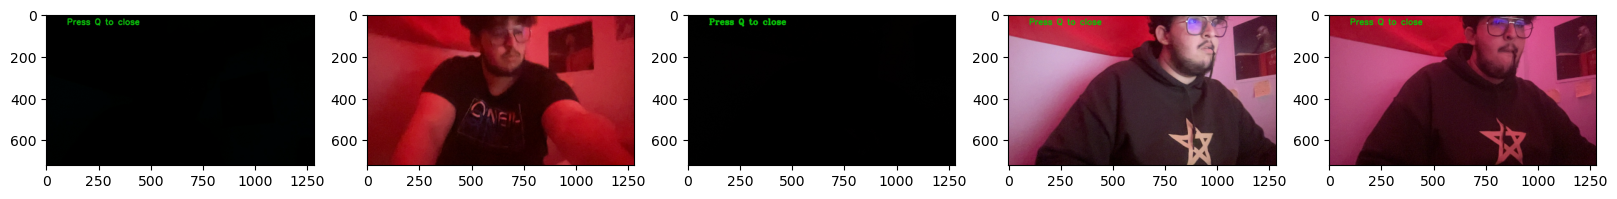

In [587]:
generator = images.batch(5).as_numpy_iterator()
batch_of_images = next(generator)
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(batch_of_images):
    ax[idx].imshow(image) 
plt.show()

Showing 5 images of the sample

In [615]:
base_path = '/Users/omar_assaadi/MachineLearning/data'

for current_folder in ['train', 'test', 'valid']:
    images_folder_path = os.path.join(base_path, current_folder, 'images')
    labels_folder_path = os.path.join(base_path, 'data', 'labels')

    for file_name in os.listdir(images_folder_path):
        json_filename = file_name.split('.')[0] + '.json'
        existing_filepath = os.path.join(labels_folder_path, json_filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join(base_path, 'data', current_folder, 'labels', json_filename)
            os.replace(existing_filepath, new_filepath)


This is to move the json files into the folder label

In [616]:
import albumentations as A


In [617]:
augmentor = A.Compose(
    [A.RandomCrop(width=450, height=450), 
                         
                         A.RandomBrightnessContrast(p=0.2),
                         A.HorizontalFlip(p=0.5), 
                         A.RGBShift(p=0.3),
                       A.RandomGamma(p=0.2), 
                         A.VerticalFlip(p=0.5)], 
                       bbox_params=A.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [618]:
label_file_path = os.path.join(base_path, 'train', 'labels', 'd3965c72-a397-11ee-a573-c6768d7bee84.json')


with open(label_file_path, 'r') as file:
    label = json.load(file)


image_path = os.path.join('/Users/omar_assaadi/MachineLearning/data', 'train', 'images', 'd3965c72-a397-11ee-a573-c6768d7bee84.jpg')
img = cv2.imread(image_path)

coordonates = [
    label['shapes'][0]['points'][0][0],
    label['shapes'][0]['points'][0][1],
    label['shapes'][0]['points'][1][0],
    label['shapes'][0]['points'][1][1]
]


We open one image of my training sample to test augmentation on it


.

In [619]:
coordonates


[104.54545454545455, 164.09090909090912, 418.18181818181813, 559.5454545454545]

In [620]:
coordonates = list(np.divide(coordonates, [1280,720,1280,720]))


In [621]:
coordonates

[0.08167613636363637,
 0.22790404040404044,
 0.3267045454545454,
 0.7771464646464646]

In [622]:
augmented = augmentor(image=img, bboxes=[coordonates], class_labels=['face'])


In [623]:
augmented['bboxes']


[(0.0, 0.0, 0.49373737373737364, 0.6997979797979798)]

In [624]:

augmented['bboxes'][0][2:]



(0.49373737373737364, 0.6997979797979798)

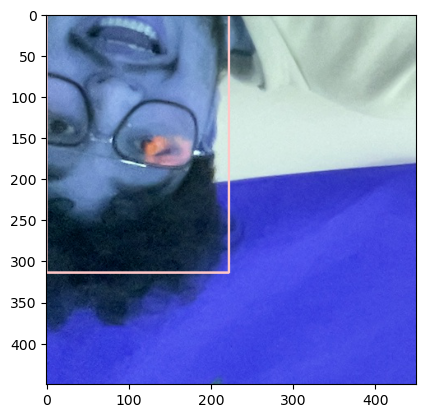

In [625]:
bbox_start = tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int))
bbox_end = tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int))

cv2.rectangle(augmented['image'], bbox_start, bbox_end, (255, 200, 200), 2)

plt.imshow(augmented['image'])
plt.show()

In [626]:
for datas in ['train','test','valid']: 
    
    for image in os.listdir(os.path.join('/Users/omar_assaadi/MachineLearning/data', datas, 'images')):
        
        single_image = cv2.imread(os.path.join('data', datas, 'images', image))

        coordonates = [0,0,0,0]
        
        json_labels = os.path.join('data', datas, 'labels', f'{image.split(".")[0]}.json')
        
        if Path(json_labels).exists():
            
            with open(json_labels, 'r') as f:
                label = json.load(f)

            coordonates = [
    label['shapes'][0]['points'][0][0],
    label['shapes'][0]['points'][0][1],
    label['shapes'][0]['points'][1][0],
    label['shapes'][0]['points'][1][1]
            ]
            coordonates = list(np.divide(coordonates, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image= single_image, bboxes=[coordonates], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', datas, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                info = {'image': image}


                if Path(json_labels).exists():
                    if len(augmented['bboxes']) != 0: 
                        info['bbox'] = augmented['bboxes'][0]
                        info['class'] = 1
                        
                    else: 
                        info['bbox'] = [0,0,0,0]
                        info['class'] = 0 
                else: 
                    info['bbox'] = [0,0,0,0]
                    info['class'] = 0 

                output_path = os.path.join('aug_data', datas, 'labels', f'{image.split(".")[0]}.{x}.json')
                with open(output_path, 'w') as f:
                    json.dump(info, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type


We basically do the same but for every image and every label of the datasets. We augment every image and label multiple times


.

In [627]:
base_path = '/Users/omar_assaadi/MachineLearning/aug_data/'

img_traindt = preprocess_dataset(base_path + 'train/images/*.jpg')
img_testdt = preprocess_dataset(base_path + 'test/images/*.jpg')
img_validdt = preprocess_dataset(base_path + 'valid/images/*.jpg')

In [883]:
base_path = '/Users/omar_assaadi/MachineLearning/aug_data/'

labl_traindt = tf.data.Dataset.list_files(base_path + 'train/labels/*.json', shuffle=False)
labl_traindt = labl_traindt.map(load_labels_wrapper)

labl_testdt = tf.data.Dataset.list_files(base_path + 'test/labels/*.json', shuffle=False)
labl_testdt = labl_testdt.map(load_labels_wrapper)

labl_validdt = tf.data.Dataset.list_files(base_path + 'valid/labels/*.json', shuffle=False)
labl_validdt = labl_validdt.map(load_labels_wrapper)

Load the images and labels to the tensorflow dataset

In [628]:
print('trained images:'+str(len(img_traindt)),
'trained labels:'+str(len(labl_traindt)),
'tested images:'+str(len(img_testdt)),
'tested labels:'+str(len(labl_testdt)),
'validated images:'+str(len(img_validdt)),
'validated labels:'+str(len(labl_validdt)))


trained images:6360 trained labels:6360 tested images:1380 tested labels:1380 validated images:1320 validated labels:1320


In [629]:
batch_size = 8
prefetch_size = 4

train = preprocess_and_zip(img_traindt, labl_traindt, shuffle_size=7000, batch_size=batch_size, prefetch_size=prefetch_size)
test = preprocess_and_zip(img_testdt, labl_testdt, shuffle_size=1800, batch_size=batch_size, prefetch_size=prefetch_size)
valid = preprocess_and_zip(img_validdt, labl_validdt, shuffle_size=1700, batch_size=batch_size, prefetch_size=prefetch_size)


Creating the final augmented dataset

In [630]:
train.as_numpy_iterator().next()[1]


2023-12-30 02:24:11.184015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [6360]
	 [[{{node Placeholder/_5}}]]
2023-12-30 02:24:11.184353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6360]
	 [[{{node Placeholder/_0}}]]


(array([[1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.9453 , 0.635  , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.353  , 0.5    , 1.     ],
        [0.783  , 0.05496, 1.     , 0.7964 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1935 , 0.08386, 0.7695 , 0.74   ],
        [0.1503 , 0.4983 , 0.6875 , 1.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [631]:
data_samples = train.as_numpy_iterator()


In [632]:
generate_sample = data_samples.next()


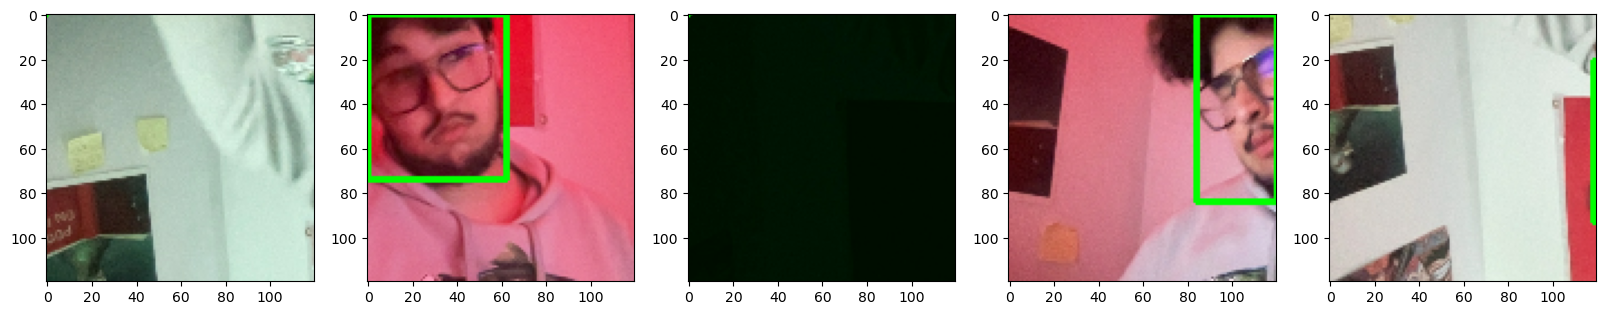

In [715]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))

for idx, (sample_image, sample_coords) in enumerate(zip(generate_sample[0][:5], generate_sample[1][1][:5])):
    bbox_start = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
    bbox_end = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))

    cv2.rectangle(sample_image, bbox_start, bbox_end, (0, 255, 0), 2)
    ax[idx].imshow(sample_image)

Testing on a generated sample if everything works


.

In [716]:
face_detector = neural_network_creation()


Creation of our neural network

In [717]:
face_detector.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_12[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d_10 (Globa  (None, 512)         0           ['vgg16[0][0]']                  
 lMaxPooling2D)                                                                             

In [718]:
batches_per_epoch = len(train)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=(1./0.75 -1)/batches_per_epoch)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



Creating and defining an optimizer using Adam

In [736]:
X, y = train.as_numpy_iterator().next()


In [737]:
classifloss = BinaryCrossentropy()
regressloss = regress_loss_function

One of the most important part, we call the loss functions on classification and regression of bounding boxes

In [738]:
classes, coordonates = facetracker.predict(X)


1/1 [==============================] - 0s 234ms/step


In [739]:
regress_loss_function(y[1], coordonates)


<tf.Tensor: shape=(), dtype=float32, numpy=6.9479885>

In [740]:
classifloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.7512654>

In [741]:
regressloss(y[1], coordonates)


<tf.Tensor: shape=(), dtype=float32, numpy=6.9479885>

In [787]:
class face_detection_model(Model): 
    
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classifloss, regloss, **kwargs):
        super().compile(**kwargs)
        self.class_loss = classifloss
        self.reg_loc_loss = regloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch

        
        with tf.GradientTape() as tape: 
            classes, coordonates = self.model(X, training=True)
            
            batch_classloss = self.class_loss(y[0], classes)
            batch_reglocloss = self.reg_loc_loss(tf.cast(y[1], tf.float32), coordonates)
            
            total_loss = batch_reglocloss + 0.6 * batch_classloss
            
            total_loss_gradient = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(total_loss_gradient, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_reglocloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coordonates = self.model(X, training=False)
        
        batch_classloss = self.class_loss(y[0], classes)
        batch_reglocloss = self.reg_loc_loss(tf.cast(y[1], tf.float32), coordonates)
        total_loss = batch_reglocloss+ 0.6 * batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_reglocloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

Creation of our class, where we load our neural network and train it and test it. Also using gradient to minimize the total loss

In [788]:
model = face_detection_model(face_detector)


We run our model.

In [789]:
model.compile(opt, classifloss, regressloss)


In [790]:
logdir='logs'


In [791]:
callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [792]:
training = model.fit(train, epochs=10, validation_data=valid,callbacks=[callback])


Epoch 1/10
795/795 [==============================] - ETA: 0s - total_loss: 0.3959 - class_loss: 0.1180 - regress_loss: 0.3250

2023-12-30 03:24:48.921287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1320]
	 [[{{node Placeholder/_0}}]]
2023-12-30 03:24:48.922194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [1320]
	 [[{{node Placeholder/_5}}]]


795/795 [==============================] - 850s 1s/step - total_loss: 0.3962 - class_loss: 0.1180 - regress_loss: 0.3254 - val_total_loss: 0.4450 - val_class_loss: 0.1568 - val_regress_loss: 0.3510
Epoch 2/10
795/795 [==============================] - 889s 1s/step - total_loss: 0.2398 - class_loss: 0.0728 - regress_loss: 0.1961 - val_total_loss: 0.8418 - val_class_loss: 0.4740 - val_regress_loss: 0.5574
Epoch 3/10
795/795 [==============================] - 1026s 1s/step - total_loss: 0.1476 - class_loss: 0.0420 - regress_loss: 0.1224 - val_total_loss: 0.0526 - val_class_loss: 0.0026 - val_regress_loss: 0.0511
Epoch 4/10
795/795 [==============================] - 1082s 1s/step - total_loss: 0.0994 - class_loss: 0.0274 - regress_loss: 0.0829 - val_total_loss: 0.0682 - val_class_loss: 0.0202 - val_regress_loss: 0.0561
Epoch 5/10
795/795 [==============================] - 1088s 1s/step - total_loss: 0.0686 - class_loss: 0.0189 - regress_loss: 0.0573 - val_total_loss: 0.0353 - val_class_los

We train it

In [793]:
training.history


{'total_loss': [0.6696866154670715,
  0.024036897346377373,
  0.24854731559753418,
  0.011704465374350548,
  0.011839622631669044,
  0.42679524421691895,
  0.008227704092860222,
  0.022371087223291397,
  0.009066798724234104,
  0.027780750766396523],
 'class_loss': [0.11552126705646515,
  0.005207313224673271,
  0.0720316544175148,
  0.0008012144826352596,
  0.006489104591310024,
  0.5328143239021301,
  8.581810106988996e-05,
  7.06881401129067e-05,
  0.0006954434793442488,
  0.011910507455468178],
 'regress_loss': [0.6003738641738892,
  0.02091250941157341,
  0.2053283154964447,
  0.011223736219108105,
  0.007946159690618515,
  0.10710662603378296,
  0.008176213130354881,
  0.022328674793243408,
  0.008649532683193684,
  0.020634446293115616],
 'val_total_loss': [0.4450228214263916,
  0.8417618274688721,
  0.0526408851146698,
  0.06819958984851837,
  0.035265419632196426,
  1.9914757013320923,
  0.03905235975980759,
  0.017577175050973892,
  0.010275579988956451,
  1.440949559211731],

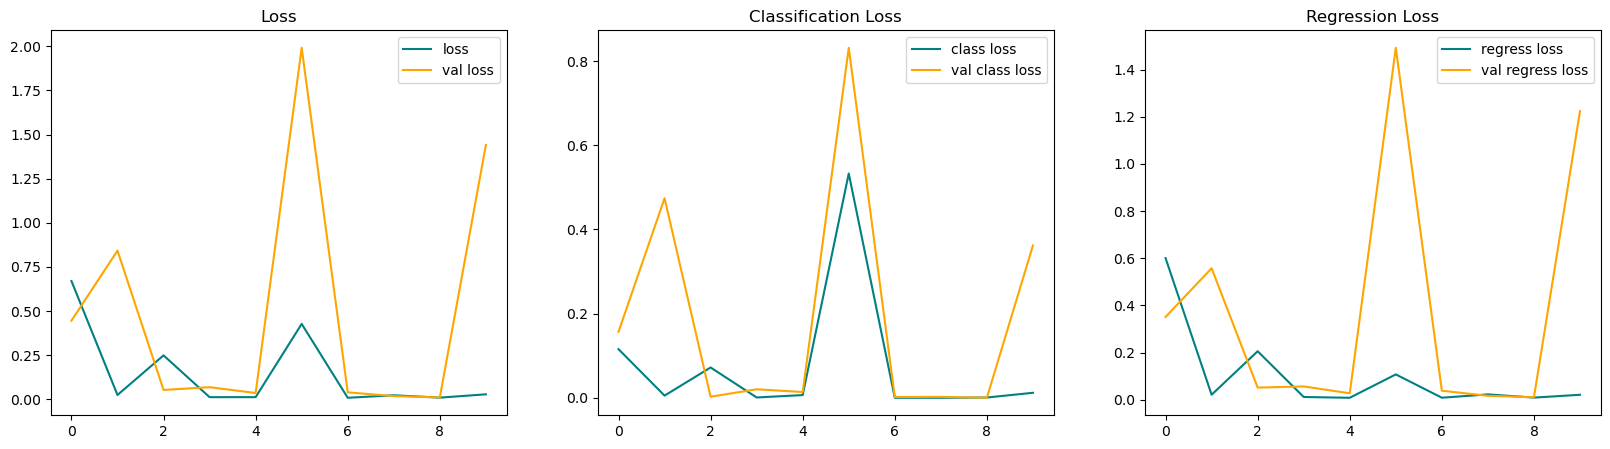

In [859]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

plot_loss(ax[0], 'Loss', 'total_loss', 'val_total_loss', 'loss', 'val loss', 'teal')
plot_loss(ax[1], 'Classification Loss', 'class_loss', 'val_class_loss', 'class loss', 'val class loss', 'teal')
plot_loss(ax[2], 'Regression Loss', 'regress_loss', 'val_regress_loss', 'regress loss', 'val regress loss', 'teal')

plt.show()

We look at discrepancies

In [853]:
test_data = test.as_numpy_iterator()


In [876]:
test_sample = test_data.next()


In [877]:
yhat = face_detector.predict(test_sample[0])


1/1 [==============================] - 0s 313ms/step


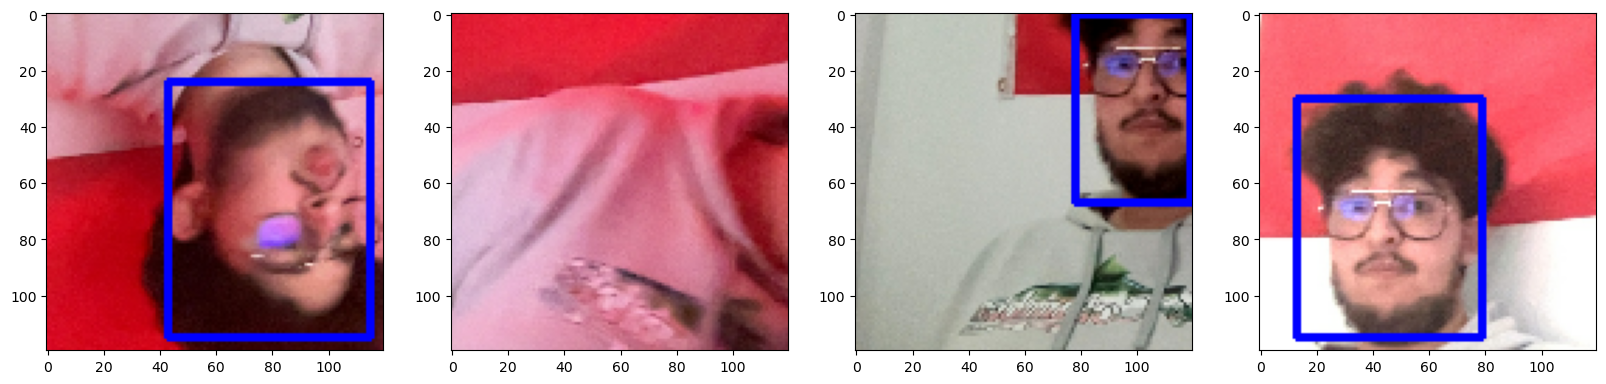

In [879]:
import matplotlib.pyplot as plt

confidence_threshold = 0.9

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    test_img = test_sample[0][idx]
    test_coord = yhat[1][idx]

    if yhat[0][idx] > confidence_threshold:
        # Extracting coordinates
        top_left = tuple(np.multiply(test_coord[:2], [120, 120]).astype(int))
        bottom_right = tuple(np.multiply(test_coord[2:], [120, 120]).astype(int))

        # Drawing rectangle using OpenCV
        cv2.rectangle(test_img, top_left, bottom_right, (0, 0, 240), 2)

    # Display the image in Matplotlib subplot
    ax[idx].imshow(test_img)

plt.show()


We do a final check with our test set to see that it works correctly and it that the model trained well

In [828]:
from tensorflow.keras.models import load_model


In [829]:
face_detector.save('face_detector.h5')


In [830]:
face_detector = load_model('face_detector.h5')


We load the model and use OPENCV for live face detection

In [881]:
import cv2
import tensorflow as tf
import numpy as np

cap = cv2.VideoCapture(0)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = face_detector.predict(np.expand_dims(resized / 255, 0))
    coordonates = yhat[1][0]

    if yhat[0] > 0.9:
        # Main rectangle
        main_rect_start = tuple(np.multiply(coordonates[:2], [450, 450]).astype(int))
        main_rect_end = tuple(np.multiply(coordonates[2:], [450, 450]).astype(int))
        cv2.rectangle(frame, main_rect_start, main_rect_end, (0, 200, 200), 2)

        # Label rectangle
        label_rect_start = tuple(np.add(main_rect_start, [0, -70]))
        label_rect_end = tuple(np.add(main_rect_start, [150, 0]))
        cv2.rectangle(frame, label_rect_start, label_rect_end, (0, 200, 200), -1)

        # Rendered text
        text_position = tuple(np.add(main_rect_start, [5, -5]))
        cv2.putText(frame, 'face', text_position, cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 2, cv2.LINE_4)

    cv2.imshow('FaceDetector', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[ WARN:0@133632.180] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


1/1 [==============================] - 0s 48ms/step
